# Load Data

In [21]:
!pip install wandb

In [2]:
!pip install datasets

In [3]:
!pip install underthesea

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from underthesea import pos_tag
from difflib import SequenceMatcher
from collections import Counter
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, classification_report
import torch
import os
from datasets import Dataset, DatasetDict, load
from sklearn.model_selection import train_test_split
from collections import defaultdict
from joblib import Parallel, delayed

In [5]:
df = pd.read_excel('/content/ViLegalNLI.xlsx')

In [6]:
df.head(3)

,Hypothesis,Premise,Text,Aspect,Website,Label,List Evidence,Explanation,File Path,Text Length
0,Cơ quan kho bạc nhà nước phải thực hiện việc t...,4. Cơ quan kho bạc nhà nước có trách nhiệm a T...,QUYẾT ĐỊNH QUY ĐỊNH VỀ MỨC THU TIỀN SỬ DỤNG KH...,tài chính nhà nước,https://thuvienphapluat.vn/,0,"""Không được chuyển việc thu tiền sang ngày hôm...",Bằng chứng chỉ ra rõ ràng rằng cơ quan kho bạc...,/content/drive/MyDrive/[DS201 + DS310] ĐỒ Á...,2232
1,Quyết định này có thể đến từ một sự thay đổi t...,4. Cơ quan kho bạc nhà nước có trách nhiệm a T...,QUYẾT ĐỊNH QUY ĐỊNH VỀ MỨC THU TIỀN SỬ DỤNG KH...,tài chính nhà nước,https://thuvienphapluat.vn/,1,NaN,Nội dung không đề cập đến lý do cụ thể tại sao...,/content/drive/MyDrive/[DS201 + DS310] ĐỒ Á...,2232
2,Ủy ban nhân dân huyện Cần Giờ không có trách n...,4. Cơ quan kho bạc nhà nước có trách nhiệm a T...,QUYẾT ĐỊNH QUY ĐỊNH VỀ MỨC THU TIỀN SỬ DỤNG KH...,tài chính nhà nước,https://thuvienphapluat.vn/,2,"""Ủy ban nhân dân huyện Cần Giờ có trách nhiệm ...",Bằng chứng cho thấy rõ ràng rằng Ủy ban nhân d...,/content/drive/MyDrive/[DS201 + DS310] ĐỒ Á...,2232


In [7]:
def split_data(df, test_size=0.1, dev_size=0.1):
    grouped = list(df.groupby('Text'))
    train_groups, temp_groups = train_test_split(grouped, test_size=(test_size + dev_size), random_state=42)
    dev_size_adjusted = dev_size / (test_size + dev_size)
    dev_groups, test_groups = train_test_split(temp_groups, test_size=1 - dev_size_adjusted, random_state=42)
    def flatten(groups):
        return pd.concat([group for _, group in groups])
    train_df = flatten(train_groups)
    dev_df = flatten(dev_groups)
    test_df = flatten(test_groups)
    return train_df, dev_df, test_df

# EDA

In [ ]:
print('Các cột của dữ liệu:')
df.columns

Các cột của dữ liệu:


Index(['Hypothesis', 'Premise', 'Text', 'Aspect', 'Website', 'Label',
       'List Evidence', 'Explanation', 'File Path', 'Text Length'],
      dtype='object')

In [ ]:
df.shape

(9696, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9696 entries, 0 to 9695
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Hypothesis     9683 non-null   object
 1   Premise        9672 non-null   object
 2   Text           9696 non-null   object
 3   Aspect         9696 non-null   object
 4   Website        9696 non-null   object
 5   Label          9696 non-null   int64 
 6   List Evidence  6455 non-null   object
 7   Explanation    9683 non-null   object
 8   File Path      9696 non-null   object
 9   Text Length    9696 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 757.6+ KB


In [ ]:
df['Text Length'].describe()

,Text Length
count,9696.000000
mean,2379.910994
std,2144.164501
min,33.000000
25%,828.000000
50%,1361.000000
75%,3431.000000
max,8285.000000


In [ ]:
# Kiểm tra giá trị trùng nhau
print('Số giá trị trùng nhau của bộ dữ liệu:',df.duplicated().sum())

Số giá trị trùng nhau của bộ dữ liệu: 0


In [ ]:
def missing_values_table(df):
    if df.isnull().sum().any():
        print('Số giá trị khuyết của bộ dữ liệu:')
        print(df.isnull().sum())
    else:
        print('Bộ dữ liệu không có giá trị khuyết')

In [ ]:
missing_values_table(df)

Số giá trị khuyết của bộ dữ liệu:
Hypothesis         13
Premise            24
Text                0
Aspect              0
Website             0
Label               0
List Evidence    3241
Explanation        13
File Path           0
Text Length         0
dtype: int64


In [8]:
# Xử lý giá trị khuyết
df.dropna(subset = ['Premise', 'Hypothesis', 'Explanation'], inplace = True)

In [ ]:
df.shape

(9667, 10)

In [ ]:
missing_values_table(df)

Số giá trị khuyết của bộ dữ liệu:
Hypothesis          0
Premise             0
Text                0
Aspect              0
Website             0
Label               0
List Evidence    3223
Explanation         0
File Path           0
Text Length         0
dtype: int64


In [9]:
# Hàm đếm số từ trong câu
def count_words(sentence):
    return len(sentence.split())

# Đếm số từ trong từng câu của cột 'Premise' và 'Hypothesis'
df['Premise_Length'] = df['Premise'].apply(count_words)
df['Hypothesis_Length'] = df['Hypothesis'].apply(count_words)

In [10]:
train_df, dev_df, test_df = split_data(df)

In [ ]:
def create_hypothesis_table(train, dev, test, group_by):
    # Tính tổng số từ
    train_count = train.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Train'})
    dev_count = dev.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Dev'})
    test_count = test.groupby(group_by).agg({'Hypothesis_Length': 'sum'}).rename(columns={'Hypothesis_Length': 'Hypothesis_Test'})

    # Hợp nhất
    merged = train_count.merge(dev_count, left_index=True, right_index=True)
    merged = merged.merge(test_count, left_index=True, right_index=True)
    merged['Total'] = merged.sum(axis=1)

    return merged.reset_index()

In [ ]:
# Tạo bảng Hypothesis cho Aspect và Label
hypothesis_aspect_table = create_hypothesis_table(train_df, dev_df, test_df, 'Aspect')
hypothesis_label_table = create_hypothesis_table(train_df, dev_df, test_df, 'Label')

In [ ]:
hypothesis_aspect_df = pd.DataFrame(hypothesis_aspect_table)
hypothesis_label_df = pd.DataFrame(hypothesis_label_table)

print("Hypothesis Table (Aspect):")
hypothesis_aspect_df

Hypothesis Table (Aspect):


,Aspect,Hypothesis_Train,Hypothesis_Dev,Hypothesis_Test,Total
0,bất động sản,4800,645,679,6124
1,bộ máy hành chính,67409,9349,8702,85460
2,chứng khoán,1227,193,186,1606
3,công nghệ thông tin,4164,738,527,5429
4,doanh nghiệp,1375,319,173,1867
5,dân sự,7071,1660,651,9382
6,giao thông - vận tải,12018,724,974,13716
7,giáo dục,10821,692,1554,13067
8,khác,15501,1912,2396,19809
9,kế toán - kiểm toán,715,266,363,1344


In [ ]:
print("\nHypothesis Table (Label):")
hypothesis_label_df


Hypothesis Table (Label):


,Label,Hypothesis_Train,Hypothesis_Dev,Hypothesis_Test,Total
0,0,77274,10190,9842,97306
1,1,62526,8174,7897,78597
2,2,59342,7770,7488,74600


In [ ]:
sum_train = train_df['Hypothesis_Length'].sum()
sum_dev = dev_df['Hypothesis_Length'].sum()
sum_test = test_df['Hypothesis_Length'].sum()
sum_total = df['Hypothesis_Length'].sum()
print('Total')
print(f'Train: {sum_train}')
print(f'Dev: {sum_dev}')
print(f'Test: {sum_test}')
print(f'Data: {sum_total}')

Total
Train: 199142
Dev: 26134
Test: 25227
Data: 250503


In [ ]:
# Tính MHL cho từng tập dữ liệu
mhl_train = train_df['Hypothesis_Length'].mean()
mhl_dev = dev_df['Hypothesis_Length'].mean()
mhl_test = test_df['Hypothesis_Length'].mean()
mhl_total = df['Hypothesis_Length'].mean()

print(f"MHL - Train: {mhl_train}")
print(f"MHL - Dev: {mhl_dev}")
print(f"MHL - Test: {mhl_test}")
print(f"MHL - Data: {mhl_total}")

MHL - Train: 25.892861786503705
MHL - Dev: 25.84965380811078
MHL - Test: 26.141968911917097
MHL - Data: 25.91320988931416


In [ ]:
# Tính MPL cho từng tập dữ liệu
mpl_train = train_df['Premise_Length'].mean()
mpl_dev = dev_df['Premise_Length'].mean()
mpl_test = test_df['Premise_Length'].mean()
mpl_total = df['Premise_Length'].mean()

print(f"MPL - Train: {mpl_train}")
print(f"MPL - Dev: {mpl_dev}")
print(f"MPL - Test: {mpl_test}")
print(f"MPL - Data: {mpl_total}")

MPL - Train: 423.7845533740736
MPL - Dev: 420.21958456973294
MPL - Test: 426.06321243523314
MPL - Data: 423.6391848556946


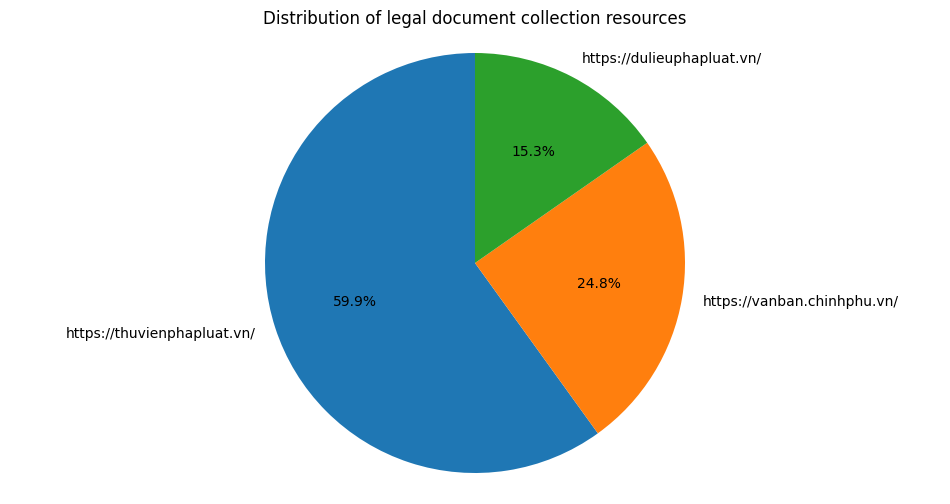

In [ ]:
website_counts = df['Website'].value_counts()

plt.figure(figsize=(12, 6))
plt.pie(website_counts, labels=website_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of legal document collection resources")
plt.axis('equal')
plt.show()

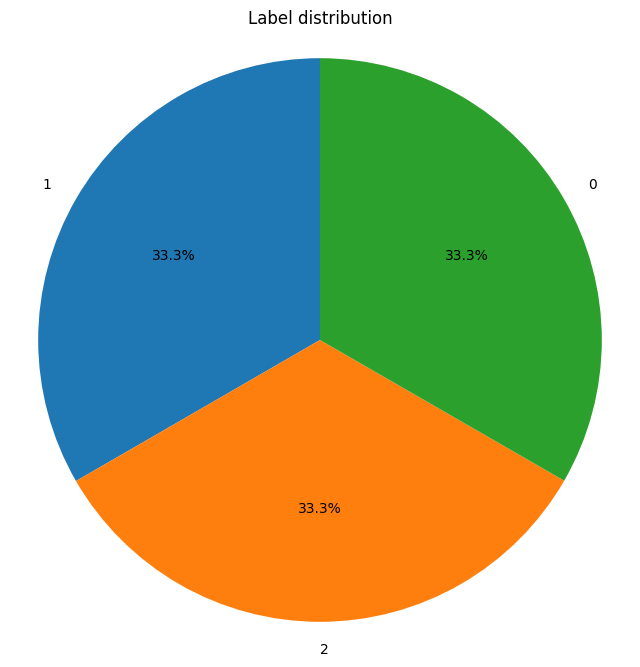

In [ ]:
# Phân phối nhãn
label_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Label distribution')
plt.axis('equal')
plt.show()

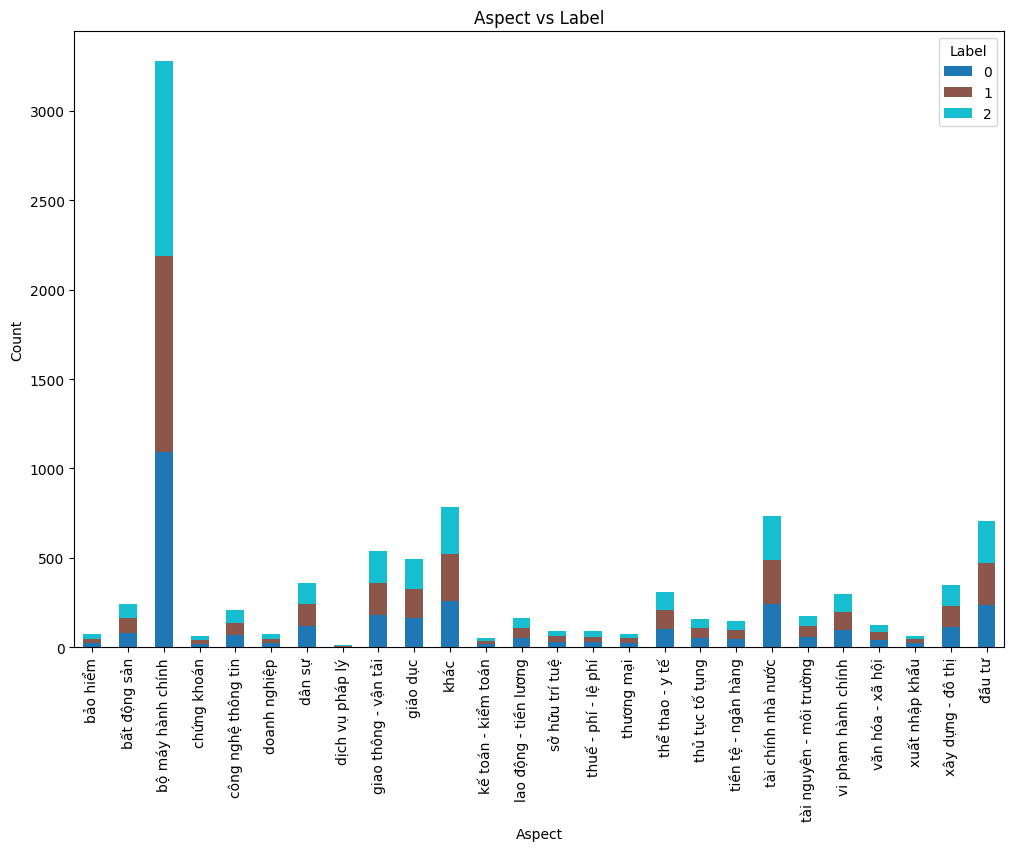

In [ ]:
# Mối quan hệ giữa label và aspect
aspect_label_counts = df.groupby(['Aspect', 'Label']).size().unstack()
aspect_label_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab10')
plt.title("Aspect vs Label")
plt.ylabel("Count")
plt.xlabel("Aspect")
plt.show()

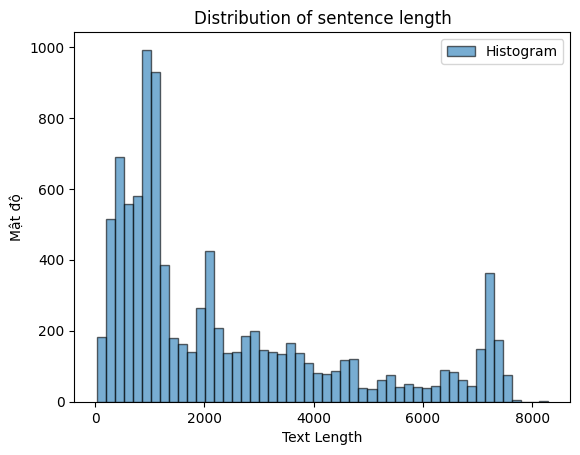

In [ ]:
plt.hist(df['Text Length'], bins=50, edgecolor='black', alpha=0.6, label="Histogram")

plt.xlabel('Text Length')
plt.ylabel('Mật độ')
plt.title("Distribution of sentence length")
plt.legend()
plt.show()

Tổng giá trị của các chủ đề duy nhất: 26 



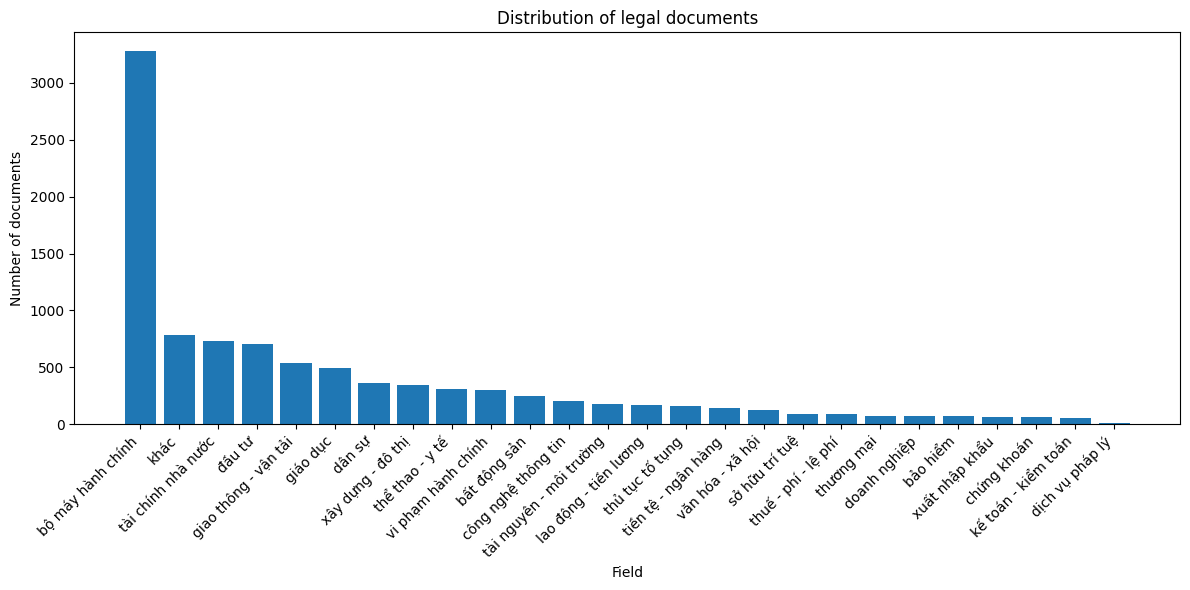

In [ ]:
# Phân phối lĩnh vực văn bản luật
print('Tổng giá trị của các chủ đề duy nhất:', df['Aspect'].nunique(),'\n')
aspect_counts = df['Aspect'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(aspect_counts.index, aspect_counts.values)
plt.xlabel("Field")
plt.ylabel("Number of documents")
plt.title("Distribution of legal documents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# World Cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

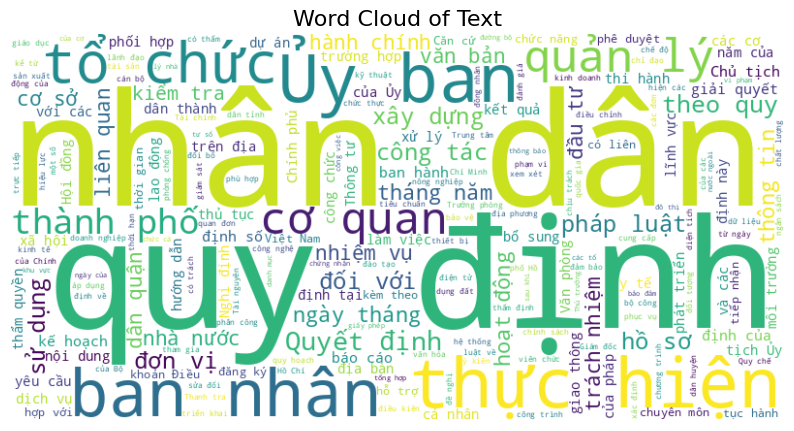

In [ ]:
plot_wordcloud(df['Text'], "Word Cloud of Text")

In [ ]:
# N-gram Analysis
def plot_ngrams(text, n=2, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text)
    ngram_counts = ngrams.sum(axis=0)
    ngram_freq = [(word, ngram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]

    ngram_df = pd.DataFrame(ngram_freq, columns=['N-gram', 'Frequency'])
    sns.barplot(data=ngram_df, x='Frequency', y='N-gram', palette='viridis')
    plt.title(f'Top {top_k} {n}-grams')
    plt.show()

<ipython-input-37-3b55f212e673>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngram_df, x='Frequency', y='N-gram', palette='viridis')


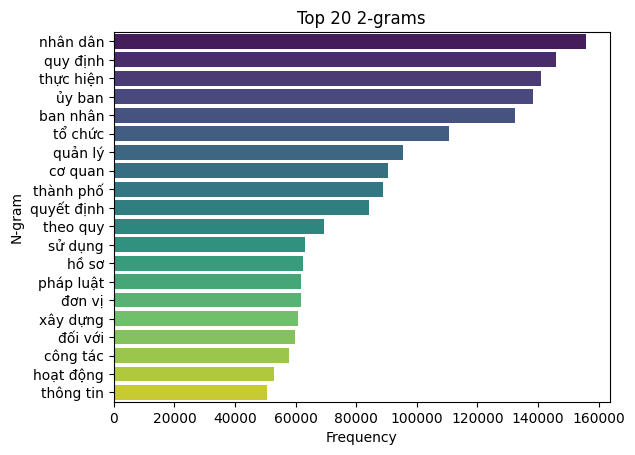

In [ ]:
plot_ngrams(df['Text'], n=2, top_k=20)

In [ ]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [ ]:
def new_word_rate(set1, set2):
    new_words = len(set2 - set1)
    return new_words / len(set2) if len(set2) != 0 else 0

In [ ]:
def longest_common_subsequence(str1, str2):
    seq_matcher = SequenceMatcher(None, str1, str2)
    return seq_matcher.find_longest_match(0, len(str1), 0, len(str2)).size

In [ ]:
def pos_distribution(text):
    pos_tags = pos_tag(text)
    pos_counts = Counter(tag for _, tag in pos_tags)
    total = sum(pos_counts.values())
    return {pos: (count / total) * 100 for pos, count in pos_counts.items()}

In [ ]:
jaccard_scores = []
new_word_rates = []
lcs_scores = []
pos_distributions = []

In [ ]:
for _, row in df.iterrows():
    premise = str(row['Premise'])
    hypothesis = str(row['Hypothesis'])

    premise_words = set(premise.split())
    hypothesis_words = set(hypothesis.split())

    # Tính toán Jaccard và Tỷ lệ từ mới
    jaccard_scores.append(jaccard_similarity(premise_words, hypothesis_words))
    new_word_rates.append(new_word_rate(premise_words, hypothesis_words))

    # Tính toán LCS
    lcs_scores.append(longest_common_subsequence(premise, hypothesis))

    # Tính toán phân phối POS
    pos_distributions.append(pos_distribution(hypothesis))

In [ ]:
data_summary = pd.DataFrame({
    'Label': df['Label'],
    'Jaccard': jaccard_scores,
    'New Word Rate': new_word_rates,
    'LCS': lcs_scores,
    'POS Distribution': pos_distributions
})

In [ ]:
# Trích xuất phần trăm POS riêng lẻ
pos_tags = ["N", "V", "A", "P", "R", "X"]
for pos in pos_tags:
    data_summary[f"POS_{pos}"] = data_summary['POS Distribution'].apply(lambda x: x.get(pos, 0))

In [ ]:
summary = data_summary.groupby('Label').agg({
    'Jaccard': 'mean',
    'New Word Rate': 'mean',
    'LCS': 'mean',
    **{f"POS_{pos}": "mean" for pos in pos_tags}
}).reset_index()

In [ ]:
summary = summary.rename(columns={
    "POS_N": "Danh từ",
    "POS_V": "Động từ",
    "POS_A": "Tính từ",
    "POS_P": "Đại từ",
    "POS_R": "Phó từ",
    "POS_X": "Khác"
})

In [ ]:
summary

,Label,Jaccard,New Word Rate,LCS,Danh từ,Động từ,Tính từ,Đại từ,Phó từ,Khác
0,0,0.108432,0.260612,34.004036,36.879959,26.712625,4.241166,0.788143,3.309566,0.021528
1,1,0.074237,0.387026,27.660565,36.293087,24.357164,3.805218,1.615545,7.161334,0.018154
2,2,0.082238,0.293001,28.923984,34.723138,24.827583,3.255743,2.843682,8.291527,0.005205


# Training

## Xây dựng pipeline

In [11]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

def load_and_preprocess_data(train_df, dev_df, test_df, tokenizer):
    def preprocess_function(examples):
        # Mã hóa Hypothesis và Premise
        tokenized = tokenizer(
            examples['Hypothesis'],  # Tên cột Hypothesis trong DataFrame
            examples['Premise'],     # Tên cột Premise trong DataFrame
            truncation=True,
            padding='max_length',
            max_length=512,          # Chỉnh sửa kích thước nếu cần
            return_tensors= 'pt'     # Loại bỏ return_tensors="pt" vì Trainer yêu cầu danh sách/mảng
        )
        tokenized['labels'] = examples['Label']  # Gán nhãn vào cột labels
        return tokenized

    # Chuyển DataFrame thành Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Áp dụng tiền xử lý và mã hóa dữ liệu
    encoded_train_dataset = train_dataset.map(lambda x: preprocess_function(x), batched=True)
    encoded_dev_dataset = dev_dataset.map(lambda x: preprocess_function(x), batched=True)
    encoded_test_dataset = test_dataset.map(lambda x: preprocess_function(x), batched=True)

    # Trả về DatasetDict chứa các dataset đã mã hóa
    return DatasetDict({
        "train": encoded_train_dataset,
        "dev": encoded_dev_dataset,
        "test": encoded_test_dataset
    })

In [12]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)  # Precision (macro-average)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)  # Recall (macro-average)
    f1 = f1_score(labels, predictions, average='macro')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [13]:
def train_and_evaluate(model_name, dataset, num_labels=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Không cần gọi tokenizer.to(device) vì tokenizer không sử dụng GPU
    # Chỉ cần huấn luyện mô hình, mô hình mới cần được chuyển sang GPU

    # Thiết lập các tham số huấn luyện
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name.replace('/', '_')}",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    os.environ["WANDB_DISABLED"] = "true"  # Tắt Weights & Biases

    # Huấn luyện mô hình với Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['dev'],
        compute_metrics=compute_metrics,  # Hàm compute_metrics bạn cần định nghĩa
    )

    # Huấn luyện mô hình
    trainer.train()
    torch.cuda.empty_cache()

    # Đánh giá mô hình trên dev và test
    dev_results = trainer.evaluate(dataset['dev'])
    test_results = trainer.evaluate(dataset['test'])

    # Trả về kết quả đánh giá và mô hình huấn luyện
    return {
        'model_name': model_name,
        'dev_accuracy': dev_results['eval_accuracy'],
        'dev_f1': dev_results['eval_f1'],
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'trainer': trainer,
        'model': model
    }

In [14]:
# Đánh giá theo từng label
def evaluate_per_label(labels, predictions):
    report = classification_report(labels, predictions, target_names=["Label 0", "Label 1", "Label 2"])  # Cập nhật tên label nếu cần
    print("Đánh giá theo từng label:\n", report)

In [15]:
def evaluate_per_aspect(df, predictions):
    # Kiểm tra và chuyển đổi `Dataset` sang pandas DataFrame nếu cần
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    # Thêm cột 'Predicted' vào DataFrame
    df['Predicted'] = predictions

    # Duyệt qua các 'Aspect' trong df
    for aspect in df['Aspect'].unique():
        aspect_data = df[df['Aspect'] == aspect]

        # Kiểm tra dữ liệu
        true_labels = aspect_data['Label'].values
        predicted_labels = aspect_data['Predicted'].values

        # In báo cáo phân loại với F1-score theo macro
        report = classification_report(true_labels, predicted_labels, target_names=["Label 0", "Label 1", "Label 2"])
        print(f"Đánh giá cho Aspect - {aspect}:\n", report)

In [16]:
def evaluate_by_length(predictions, labels, hypothesis_lengths):
    # Chia các câu thành nhóm theo chiều dài và tính accuracy và f1-score cho mỗi nhóm
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]  # Điều chỉnh bins theo yêu cầu
    labels_binned = pd.cut(hypothesis_lengths, bins)

    # Tính độ chính xác và F1-score cho mỗi nhóm
    for length_bin in labels_binned.unique():
        indices = [i for i, length in enumerate(hypothesis_lengths) if labels_binned[i] == length_bin]
        length_preds = [predictions[i] for i in indices]
        length_labels = [labels[i] for i in indices]

        # Kiểm tra số lớp trong length_labels và length_preds
        unique_labels = np.unique(length_labels)
        print(f"Số lớp trong nhóm chiều dài {length_bin}: {unique_labels}")

        # Đảm bảo các lớp trong dữ liệu của bạn khớp với target_names
        report = classification_report(length_labels, length_preds, target_names=["Label 0", "Label 1", "Label 2"], labels=np.unique(length_labels))
        print(f"Đánh giá cho chiều dài {length_bin}:\n", report)

In [17]:
def save_predictions(predictions, labels, filename="predictions.csv"):
    # Lưu kết quả dự đoán vào CSV
    df_predictions = pd.DataFrame({
        "Prediction": predictions,
        "True Label": labels,
    })
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

In [18]:
def get_predictions(trainer, dev_predictions, test_predictions):
    # Dự đoán trên dev dataset
    dev_preds = np.argmax(dev_predictions.predictions, axis=1)
    dev_labels = dev_predictions.label_ids
    print("\n________ĐÁNH GIÁ TRÊN TẬP DEV________")

    # Đánh giá cho dev
    print("Đánh giá cho dev:")
    evaluate_per_label(dev_labels, dev_preds)
    dev_metrics = compute_metrics((dev_predictions.predictions, dev_labels))
    print("Metrics trên dev:", dev_metrics)

    # Đánh giá theo từng Aspect trên dev
    print("\nĐánh giá theo từng Aspect trên dev:")
    evaluate_per_aspect(dev_df, dev_preds)


    # Đánh giá theo chiều dài câu trên dev
    print("\nĐánh giá theo từng Hypothesis Length trên dev:")
    hypothesis_lengths_dev = dev_df['Hypothesis_Length'].tolist()
    evaluate_by_length(dev_preds, dev_labels, hypothesis_lengths_dev)

    # Dự đoán trên test dataset
    test_preds = np.argmax(test_predictions.predictions, axis=1)
    test_labels = test_predictions.label_ids
    print("\n\n________ĐÁNH GIÁ TRÊN TẬP TEST________")

    # Đánh giá cho test
    print("Đánh giá cho test:")
    evaluate_per_label(test_labels, test_preds)
    test_metrics = compute_metrics((test_predictions.predictions, test_labels))
    print("Metrics trên test:", test_metrics)

    # Đánh giá theo từng Aspect trên test
    print("\nĐánh giá theo từng Aspect trên test:")
    evaluate_per_aspect(test_df, test_preds)

    # Đánh giá theo chiều dài câu trên test
    print("\nĐánh giá theo từng Hypothesis Length trên test:")
    hypothesis_lengths_test = test_df['Hypothesis_Length'].tolist()
    evaluate_by_length(test_preds, test_labels, hypothesis_lengths_test)

## Training - Evaluate

In [19]:
models = ["bert-base-multilingual-cased", "xlm-roberta-large", "uitnlp/CafeBERT"]

### BERT-Multiligual

In [ ]:
model_name = models[0]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

Đang huấn luyện mô hình: bert-base-multilingual-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.245800,0.221530,0.919881,0.923804,0.919854,0.920172
2,0.171000,0.197954,0.934718,0.937417,0.934703,0.934912
3,0.116800,0.214333,0.940653,0.942585,0.940623,0.940787
4,0.070800,0.215476,0.949555,0.949925,0.949572,0.949610
5,0.031500,0.232964,0.948566,0.949135,0.948583,0.948643


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.97      0.91      0.94       336
     Label 1       0.88      0.97      0.93       337
     Label 2       0.96      0.92      0.94       338

    accuracy                           0.93      1011
   macro avg       0.94      0.93      0.93      1011
weighted avg       0.94      0.93      0.93      1011

Metrics trên dev: {'accuracy': 0.9347181008902077, 'precision': 0.9374166238070386, 'recall': 0.9347029289536707, 'f1': 0.9349115605711508}

Đánh giá theo từng Aspect trên dev:
Đánh giá cho Aspect - bộ máy hành chính:
               precision    recall  f1-score   support

     Label 0       0.98      0.90      0.94       120
     Label 1       0.88      0.99      0.93       120
     Label 2       0.99      0.94      0.97       121

    accuracy                           0.94       361
   macro avg       0.95      0.94      0.94 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(


Đánh giá cho Aspect - lao động - tiền lương:
               precision    recall  f1-score   support

     Label 0       1.00      0.86      0.92         7
     Label 1       0.75      0.86      0.80         7
     Label 2       0.86      0.86      0.86         7

    accuracy                           0.86        21
   macro avg       0.87      0.86      0.86        21
weighted avg       0.87      0.86      0.86        21

Đánh giá cho Aspect - đầu tư:
               precision    recall  f1-score   support

     Label 0       1.00      0.82      0.90        22
     Label 1       0.81      1.00      0.90        22
     Label 2       0.95      0.91      0.93        22

    accuracy                           0.91        66
   macro avg       0.92      0.91      0.91        66
weighted avg       0.92      0.91      0.91        66

Đánh giá cho Aspect - thuế - phí - lệ phí:
               precision    recall  f1-score   support

     Label 0       1.00      0.75      0.86         4
     Lab

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)

### XLMR-Large

In [22]:
model_name = models[1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

Đang huấn luyện mô hình: xlm-roberta-large


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.104400,1.101663,0.333333,0.777778,0.333333,0.166667
2,1.111800,1.098706,0.332344,0.777448,0.333333,0.166295
3,1.109100,1.100230,0.332344,0.777448,0.333333,0.166295
4,1.096900,1.099112,0.333333,0.777778,0.333333,0.166667
5,1.105300,1.098610,0.334322,0.778107,0.333333,0.167037


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00       336
     Label 1       0.00      0.00      0.00       337
     Label 2       0.33      1.00      0.50       338

    accuracy                           0.33      1011
   macro avg       0.11      0.33      0.17      1011
weighted avg       0.11      0.33      0.17      1011

Metrics trên dev: {'accuracy': 0.334322453016815, 'precision': 0.7781074843389383, 'recall': 0.3333333333333333, 'f1': 0.16703731158883126}

Đánh giá theo từng Aspect trên dev:
Đánh giá cho Aspect - bộ máy hành chính:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00       120
     Label 1       0.00      0.00      0.00       120
     Label 2       0.34      1.00      0.50       121

    accuracy                           0.34       361
   macro avg       0.11      0.33      0.17 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Đánh giá cho Aspect - doanh nghiệp:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00         4
     Label 1       0.00      0.00      0.00         4
     Label 2       0.33      1.00      0.50         4

    accuracy                           0.33        12
   macro avg       0.11      0.33      0.17        12
weighted avg       0.11      0.33      0.17        12

Đánh giá cho Aspect - thể thao - y tế:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        11
     Label 1       0.00      0.00      0.00        11
     Label 2       0.33      1.00      0.50        11

    accuracy                           0.33        33
   macro avg       0.11      0.33      0.17        33
weighted avg       0.11      0.33      0.17        33

Đánh giá cho Aspect - thương mại:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00         2
     Label 1     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Đánh giá cho Aspect - xây dựng - đô thị:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        14
     Label 1       0.00      0.00      0.00        14
     Label 2       0.33      1.00      0.50        14

    accuracy                           0.33        42
   macro avg       0.11      0.33      0.17        42
weighted avg       0.11      0.33      0.17        42

Đánh giá cho Aspect - tài chính nhà nước:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        16
     Label 1       0.00      0.00      0.00        16
     Label 2       0.33      1.00      0.50        16

    accuracy                           0.33        48
   macro avg       0.11      0.33      0.17        48
weighted avg       0.11      0.33      0.17        48

Đánh giá cho Aspect - giáo dục:
               precision    recall  f1-score   support

     Label 0       0.00      0.00      0.00        21
     Label 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

### CafeBERT

In [ ]:
model_name = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/7691 [00:00<?, ? examples/s]

Map:   0%|          | 0/1011 [00:00<?, ? examples/s]

Map:   0%|          | 0/965 [00:00<?, ? examples/s]

Đang huấn luyện mô hình: uitnlp/CafeBERT


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.196800,0.222881,0.926805,0.932301,0.926763,0.927233
2,0.101300,0.211906,0.943620,0.944365,0.943658,0.943636
3,0.092700,0.265845,0.941642,0.941988,0.941642,0.941588
4,0.079900,0.310914,0.949555,0.949933,0.949590,0.949547
5,0.026900,0.306284,0.950544,0.950695,0.950547,0.950561


In [ ]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [ ]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.94      0.96      0.95       336
     Label 1       0.92      0.96      0.94       337
     Label 2       0.97      0.92      0.94       338

    accuracy                           0.94      1011
   macro avg       0.94      0.94      0.94      1011
weighted avg       0.94      0.94      0.94      1011

Metrics trên dev: {'accuracy': 0.9436201780415431, 'precision': 0.9443651890955813, 'recall': 0.943657959821507, 'f1': 0.9436356235018359}

Đánh giá theo từng Aspect trên dev:
Đánh giá cho Aspect - bộ máy hành chính:
               precision    recall  f1-score   support

     Label 0       0.98      0.97      0.98       120
     Label 1       0.93      0.97      0.95       120
     Label 2       0.97      0.94      0.96       121

    accuracy                           0.96       361
   macro avg       0.96      0.96      0.96  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 1, does not match size of target_names, 3
  warnings.warn(


Đánh giá cho Aspect - tài chính nhà nước:
               precision    recall  f1-score   support

     Label 0       0.88      0.94      0.91        16
     Label 1       0.94      0.94      0.94        16
     Label 2       0.93      0.88      0.90        16

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48

Đánh giá cho Aspect - giáo dục:
               precision    recall  f1-score   support

     Label 0       0.95      0.86      0.90        21
     Label 1       0.91      1.00      0.95        21
     Label 2       0.90      0.90      0.90        21

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63

Đánh giá cho Aspect - dân sự:
               precision    recall  f1-score   support

     Label 0       1.00      0.88      0.93         8
     Label 1       0.7

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Training với ViNLI

### Load Data

In [5]:
train_set = pd.read_json('/content/UIT_ViNLI_1.0_train.jsonl', lines=True)
dev_set = pd.read_json('/content/UIT_ViNLI_1.0_dev.jsonl', lines=True)
test_set = pd.read_json('/content/UIT_ViNLI_1.0_test.jsonl', lines=True)

In [6]:
train_df = train_set[['sentence1', 'sentence2', 'gold_label']].copy()
dev_df = dev_set[['sentence1', 'sentence2', 'gold_label']].copy()
test_df = test_set[['sentence1', 'sentence2', 'gold_label']].copy()

valid_labels = {'entailment', 'neutral', 'contradiction'}

train_df = train_df[train_df['gold_label'].isin(valid_labels)]
dev_df = dev_df[dev_df['gold_label'].isin(valid_labels)]
test_df = test_df[test_df['gold_label'].isin(valid_labels)]

In [7]:
label_mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

train_df['Label'] = train_df['gold_label'].map(label_mapping)
dev_df['Label'] = dev_df['gold_label'].map(label_mapping)
test_df['Label'] = test_df['gold_label'].map(label_mapping)

In [8]:
train_df.head(1)

,sentence1,sentence2,gold_label,Label
0,"Sau dự án điện mặt trời, Tập đoàn Trung Nam vừ...",Công ty Hitachi Sustainable Energy có cổ phần ...,entailment,0


In [8]:
df = pd.concat([train_df, dev_df, test_df], ignore_index=True)

In [9]:
models = ["bert-base-multilingual-cased", "xlm-roberta-large", "uitnlp/CafeBERT"]

### Build Pipeline

In [10]:
def load_and_preprocess_data(train_df, dev_df, test_df, tokenizer):
    def preprocess_function(examples):
        # Mã hóa Hypothesis và Premise
        tokenized = tokenizer(
            examples['sentence1'],  # Tên cột Hypothesis trong DataFrame
            examples['sentence2'],     # Tên cột Premise trong DataFrame
            truncation=True,
            padding='max_length',
            max_length=512,          # Chỉnh sửa kích thước nếu cần
            return_tensors= 'pt'     # Loại bỏ return_tensors="pt" vì Trainer yêu cầu danh sách/mảng
        )
        tokenized['labels'] = examples['Label']  # Gán nhãn vào cột labels
        return tokenized

    # Chuyển DataFrame thành Dataset
    train_dataset = Dataset.from_pandas(train_df)
    dev_dataset = Dataset.from_pandas(dev_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Áp dụng tiền xử lý và mã hóa dữ liệu
    encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
    encoded_dev_dataset = dev_dataset.map(preprocess_function, batched=True)
    encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)

    # Trả về DatasetDict chứa các dataset đã mã hóa
    return DatasetDict({
        "train": encoded_train_dataset,
        "dev": encoded_dev_dataset,
        "test": encoded_test_dataset
    })

In [11]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=1)  # Precision (macro-average)
    recall = recall_score(labels, predictions, average='macro', zero_division=1)  # Recall (macro-average)
    f1 = f1_score(labels, predictions, average='macro')
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [12]:
def train_and_evaluate(model_name, dataset, num_labels=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Không cần gọi tokenizer.to(device) vì tokenizer không sử dụng GPU
    # Chỉ cần huấn luyện mô hình, mô hình mới cần được chuyển sang GPU

    # Thiết lập các tham số huấn luyện
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir=f"./logs/{model_name.replace('/', '_')}",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    os.environ["WANDB_DISABLED"] = "true"  # Tắt Weights & Biases

    # Huấn luyện mô hình với Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['dev'],
        compute_metrics=compute_metrics,  # Hàm compute_metrics bạn cần định nghĩa
    )

    # Huấn luyện mô hình
    trainer.train()
    torch.cuda.empty_cache()

    # Đánh giá mô hình trên dev và test
    dev_results = trainer.evaluate(dataset['dev'])
    test_results = trainer.evaluate(dataset['test'])

    # Trả về kết quả đánh giá và mô hình huấn luyện
    return {
        'model_name': model_name,
        'dev_accuracy': dev_results['eval_accuracy'],
        'dev_f1': dev_results['eval_f1'],
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'trainer': trainer,
        'model': model
    }

In [13]:
# Hàm so sánh giữa các mô hình
def compare_models(models, dataset):
    results = []

    for model_name in models:
        print(f"Đang huấn luyện và đánh giá mô hình: {model_name}")
        result = train_and_evaluate(model_name, dataset)
        results.append(result)

    # Chuyển kết quả thành DataFrame để dễ dàng hiển thị
    df_results = pd.DataFrame(results)

    # In ra bảng so sánh
    print("\nSo sánh kết quả giữa các mô hình:")
    print(df_results)

In [14]:
# Đánh giá theo từng label
def evaluate_per_label(labels, predictions):
    report = classification_report(labels, predictions, target_names=["Label 0", "Label 1", "Label 2"])  # Cập nhật tên label nếu cần
    print("Đánh giá theo từng label:\n", report)

In [15]:
def save_predictions(predictions, labels, filename="predictions.csv"):
    # Lưu kết quả dự đoán vào CSV
    df_predictions = pd.DataFrame({
        "Prediction": predictions,
        "True Label": labels,
    })
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

In [16]:
def get_predictions(trainer, dev_predictions, test_predictions):
    # Dự đoán trên dev dataset
    dev_preds = np.argmax(dev_predictions.predictions, axis=1)
    dev_labels = dev_predictions.label_ids
    print("\n________ĐÁNH GIÁ TRÊN TẬP DEV________")

    # Đánh giá cho dev
    print("Đánh giá cho dev:")
    evaluate_per_label(dev_labels, dev_preds)
    dev_metrics = compute_metrics((dev_predictions.predictions, dev_labels))
    print("Metrics trên dev:", dev_metrics)

    # Dự đoán trên test dataset
    test_preds = np.argmax(test_predictions.predictions, axis=1)
    test_labels = test_predictions.label_ids
    print("\n\n________ĐÁNH GIÁ TRÊN TẬP TEST________")

    # Đánh giá cho test
    print("Đánh giá cho test:")
    evaluate_per_label(test_labels, test_preds)
    test_metrics = compute_metrics((test_predictions.predictions, test_labels))
    print("Metrics trên test:", test_metrics)


### BERT-Multiligual

In [20]:
model_name = models[0]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/18282 [00:00<?, ? examples/s]

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Đang huấn luyện mô hình: bert-base-multilingual-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.706100,0.791253,0.653215,0.652727,0.653750,0.652564
2,0.614600,0.789765,0.651885,0.658241,0.651653,0.652657
3,0.462500,0.813432,0.670067,0.673711,0.670116,0.670721
4,0.297700,0.928144,0.663415,0.668848,0.663023,0.663956
5,0.259800,1.045130,0.668736,0.669552,0.668536,0.668480


In [21]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [22]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.67      0.65      0.66       739
     Label 1       0.71      0.62      0.66       752
     Label 2       0.59      0.69      0.64       764

    accuracy                           0.65      2255
   macro avg       0.66      0.65      0.65      2255
weighted avg       0.66      0.65      0.65      2255

Metrics trên dev: {'accuracy': 0.6518847006651884, 'precision': 0.6582412614555584, 'recall': 0.6516530535937352, 'f1': 0.6526573681409277}


________ĐÁNH GIÁ TRÊN TẬP TEST________
Đánh giá cho test:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.68      0.64      0.66       750
     Label 1       0.73      0.64      0.68       777
     Label 2       0.57      0.68      0.62       737

    accuracy                           0.65      2264
   macro avg       0.66      0.65   

### XLMR-Large

In [ ]:
model_name = models[1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

In [24]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [25]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.79      0.87      0.83       739
     Label 1       0.80      0.81      0.80       752
     Label 2       0.85      0.76      0.81       764

    accuracy                           0.81      2255
   macro avg       0.82      0.81      0.81      2255
weighted avg       0.82      0.81      0.81      2255

Metrics trên dev: {'accuracy': 0.8133037694013304, 'precision': 0.8151778211830673, 'recall': 0.8139059196234912, 'f1': 0.813047049369871}


________ĐÁNH GIÁ TRÊN TẬP TEST________
Đánh giá cho test:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.79      0.86      0.82       750
     Label 1       0.80      0.81      0.81       777
     Label 2       0.84      0.75      0.80       737

    accuracy                           0.81      2264
   macro avg       0.81      0.81    

### CafeBERT

In [19]:
model_name = models[2]
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_and_preprocess_data(train_df, dev_df, test_df, tokenizer)
print(f"Đang huấn luyện mô hình: {model_name}")
evaluation_results = train_and_evaluate(model_name, dataset)
trainer = evaluation_results['trainer']
model = evaluation_results['model']

Map:   0%|          | 0/18282 [00:00<?, ? examples/s]

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Đang huấn luyện mô hình: uitnlp/CafeBERT


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.452800,0.602387,0.772949,0.778442,0.773210,0.772976
2,0.362100,0.486915,0.821729,0.822972,0.821438,0.821689
3,0.235100,0.543030,0.814191,0.818917,0.814879,0.814031
4,0.050100,0.793867,0.823947,0.824310,0.824107,0.823855
5,0.020600,0.964450,0.820399,0.820386,0.820467,0.820385


In [20]:
dev_predictions = trainer.predict(dataset['dev'])
test_predictions = trainer.predict(dataset['test'])

In [21]:
get_predictions(trainer, dev_predictions, test_predictions)


________ĐÁNH GIÁ TRÊN TẬP DEV________
Đánh giá cho dev:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.85      0.79      0.82       739
     Label 1       0.80      0.82      0.81       752
     Label 2       0.81      0.85      0.83       764

    accuracy                           0.82      2255
   macro avg       0.82      0.82      0.82      2255
weighted avg       0.82      0.82      0.82      2255

Metrics trên dev: {'accuracy': 0.821729490022173, 'precision': 0.8229720330730759, 'recall': 0.8214378602431543, 'f1': 0.8216894233524444}


________ĐÁNH GIÁ TRÊN TẬP TEST________
Đánh giá cho test:
Đánh giá theo từng label:
               precision    recall  f1-score   support

     Label 0       0.86      0.79      0.82       750
     Label 1       0.80      0.81      0.80       777
     Label 2       0.77      0.83      0.80       737

    accuracy                           0.81      2264
   macro avg       0.81      0.81    